In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


raw_df = pd.read_hdf('./data/merged_data.h5')


In [3]:
# sns.boxplot(data=raw_df)
# 생각보다 같은 코인은 비슷한 데이터 분포를 가진 듯, 그냥 바로 train val test 나눠서 해봐도 될듯..?

In [2]:
df = raw_df.drop(columns = ['sample_id', 'time', 'coin_index'])
column_indices = {name : i for i, name in enumerate(df.columns)}
print(column_indices)

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'volume': 4, 'quote_av': 5, 'trades': 6, 'tb_base_av': 7, 'tb_quote_av': 8}


In [3]:
df.shape

(1812000, 9)

In [4]:
def df2d_to_array3d(df_2d):
    
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    
    return array_3d

In [5]:
raw_array = df2d_to_array3d(raw_df)
print(f'raw array shape is {raw_array.shape}')

raw array shape is (1208, 1500, 10)


In [6]:
len(raw_array)

1208

In [7]:
raw_array[:, :, 1:].shape

(1208, 1500, 9)

In [8]:
def train_val_test_spliter(arr):
    
    n = len(arr)
    num_features = arr.shape[2]
    
    train_arr = arr[0:int(n*0.7), :, 1:]
    val_arr = arr[int(n*0.7):int(n*0.9), :, 1:]
    test_arr = arr[int(n*0.9):, : , 1:]

    
    n2 = len(train_arr) + len(val_arr) + len(test_arr)
    
    print(
    f'''
    ======================================================
    Origin length is {n}, then total split length is {n2}
    ======================================================
    train length is {train_arr.shape},
    val length is {val_arr.shape},
    test length is {test_arr.shape},
    num_features is ({num_features})
    '''
    )
    
    return train_arr, val_arr, test_arr, num_features

In [9]:
train_arr, val_arr, test_arr, num_features = train_val_test_spliter(raw_array)


    Origin length is 1208, then total split length is 1208
    train length is (845, 1500, 9),
    val length is (242, 1500, 9),
    test length is (121, 1500, 9),
    num_features is (10)
    


In [10]:
def standard_normalizer(train_arr, val_arr, test_arr):
    
    train_mean = train_arr.mean()
    train_std = train_arr.std()

    normalized_train_arr = (train_arr - train_mean) / train_std
    normalized_val_arr = (val_arr - train_mean) / train_std
    normalized_test_arr = (test_arr - train_mean) / train_std
    
    return normalized_train_arr, normalized_val_arr, normalized_test_arr

In [11]:
# ntrain = normalized train
ntrain_arr, nval_arr, ntest_arr = standard_normalizer(train_arr, val_arr, test_arr)

In [12]:
column_indices = {name : i for i, name in enumerate(df.columns)}

In [13]:
class WindowGenerator():
    
    def __init__(self, input_width, label_width, shift, column_indices = column_indices,
               train_arr=ntrain_arr, val_arr=nval_arr, test_arr=ntest_arr,
               label_columns=None):
    
        # Store the raw data.
        self.train_arr = train_arr
        self.val_arr = val_arr
        self.test_arr = test_arr

        # Work out the label column indices.
        self.label_columns = label_columns
        
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = column_indices
        
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):

        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [14]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, column_indices = column_indices,
                     label_columns=['open'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

In [16]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
train_arr.shape

(845, 1500, 9)

In [18]:
inputs = train_arr[:, w2.input_slice, :]

In [19]:
inputs.shape

(845, 6, 9)

In [31]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_arr[:, :w2.total_window_size]), 
                           np.array(train_arr[:, 100:100+w2.total_window_size]),
                           np.array(train_arr[:, 200:200+w2.total_window_size])])

In [33]:
example_window.shape

TensorShape([3, 845, 7, 9])

In [30]:


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

ValueError: Tensor's shape (3, 6, 7, 9) is not compatible with supplied shape [None, 6, None]

In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='open', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]

    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()

    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

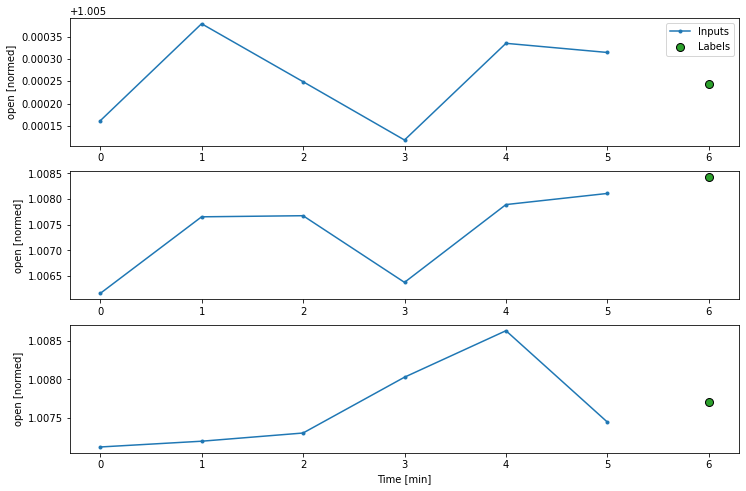

In [25]:
w2.plot()

In [26]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [36]:
 data = np.array(train_arr, dtype=np.float32)

In [50]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=7,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

In [51]:
ds

<BatchDataset shapes: (None, None, 1500, 9), types: tf.float32>

In [27]:
@property
def train(self):
    return self.make_dataset(self.train_arr)

@property
def val(self):
    return self.make_dataset(self.val_arr)

@property
def test(self):
    return self.make_dataset(self.test_arr)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [28]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['open'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['open']

In [29]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

ValueError: in user code:

    <ipython-input-16-327f433344e3>:11 split_window  *
        inputs.set_shape([None, self.input_width, None])
    C:\Anaconda3\envs\venv\lib\site-packages\tensorflow\python\framework\ops.py:762 set_shape  **
        raise ValueError(str(e))

    ValueError: Shapes must be equal rank, but are 4 and 3


In [ ]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['open'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['open'])

wide_window

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)
print('------------------------------------------------')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


In [ ]:
wide_window.plot(baseline, plot_col='open')

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(linear)

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', dense(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(dense)

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['open'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(multi_step_dense)

In [ ]:
print('Input shape:', wide_window.example[0].shape)

try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

In [ ]:
conv_model = tf.keras.Sequential([
    
#     tf.keras.layers.Flatten(),    
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     가 아래의 Conv1D로 대체됨.-> 시간 차원이 유지됨.
    
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    
    tf.keras.layers.Dense(units=32, activation='relu'),
    
#     # Shape: (outputs) => (1, outputs)
#     tf.keras.layers.Reshape([1, -1])
#     시간 차원이 유지되어 Reshape 해줄 필요가 없음.

    tf.keras.layers.Dense(units=1),
])

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)

# dense layer 같으면 input - output shape이 같았음
print('Output shape:', conv_model(wide_window.example[0]).shape)



In [ ]:
# CONV_WIDTH = 3
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['open'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
# label과 ouput shape이 일치함.
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
wide_conv_window.plot(conv_model)


In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
    print(f'{name:16s}: {value[1]:0.4f}')

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
%%time

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print() # 띄어쓰기 효과

In [ ]:
## ResNet은 변화가 작아야 효용성이 있음 Residual networks

In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

In [ ]:

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
# multi_window

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

In [ ]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

In [ ]:
multi_performance

In [ ]:


repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


In [ ]:
history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(multi_dense_model, multi_window)
IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

In [ ]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

In [ ]:
history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

In [ ]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [ ]:
multi_performance

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()